<a href="https://colab.research.google.com/github/artms-18/ML-Projects/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## STOCK PREDICTION WITH TENSORFLOW 2.0!

In this notebook, we will be predicting prices of General Electric's stock using a Transformer neural network

## Step 1 - Import data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

In [3]:
uploaded = files.upload()


Saving GE (1).csv to GE (1) (1).csv


In [4]:
for fn in uploaded.keys():
  print("User uploaded file {name} with length {length} bytes".format(name = fn, length = len(uploaded[fn])))

User uploaded file GE (1).csv with length 884373 bytes


In [6]:
import io

df = pd.read_csv(io.StringIO(uploaded['GE (1).csv'].decode('utf-8')))

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1969-01-06,0.959034,0.959034,0.939002,0.945262,0.190349,2805504
1,1969-01-07,0.941506,0.941506,0.911458,0.925230,0.186315,4233216
2,1969-01-08,0.925230,0.930238,0.907702,0.921474,0.185559,3065088
3,1969-01-09,0.921474,0.931490,0.916466,0.920222,0.185306,3065088
4,1969-01-10,0.917718,0.917718,0.906450,0.906450,0.182533,2595840


In [8]:
# Sort Dataframe by date

df = df.sort_values('Date')

# Check result

df.head()



,Date,Open,High,Low,Close,Adj Close,Volume
0,1969-01-06,0.959034,0.959034,0.939002,0.945262,0.190349,2805504
1,1969-01-07,0.941506,0.941506,0.911458,0.925230,0.186315,4233216
2,1969-01-08,0.925230,0.930238,0.907702,0.921474,0.185559,3065088
3,1969-01-09,0.921474,0.931490,0.916466,0.920222,0.185306,3065088
4,1969-01-10,0.917718,0.917718,0.906450,0.906450,0.182533,2595840


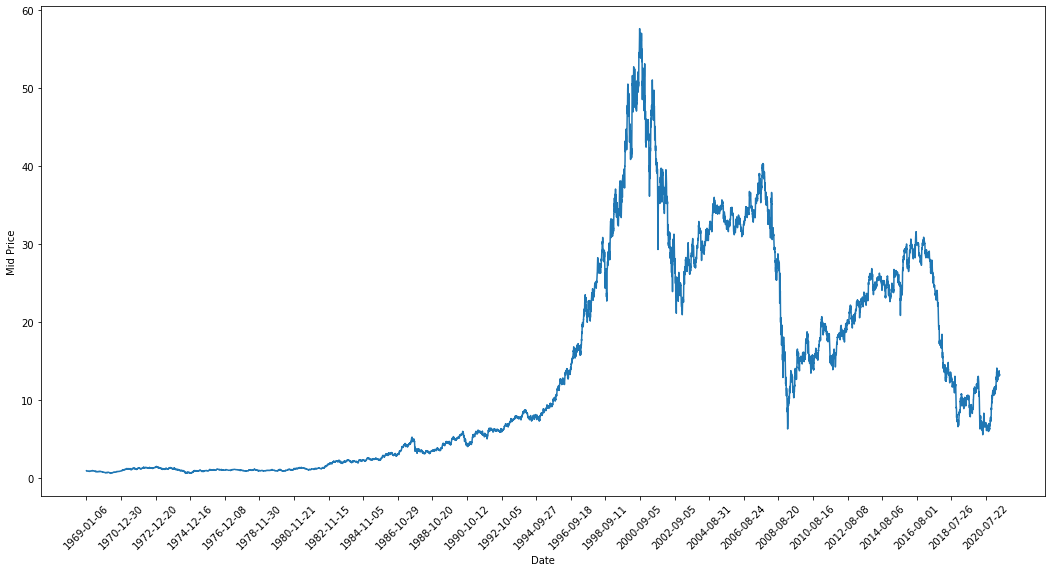

In [9]:
# Visualize data

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]), (df['Low'] + df['High'])/2.0)
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation = 45)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Mid Price', fontsize = 10)
plt.show()

## Step 2 - Data preprocessing

In [10]:
df['mid'] = (df['Low'] + df['High'])/2.0

In [11]:
SEQ_LEN = 60 # how long of a preceeding sequence to collect for RNN

FUTURE_PERIOD_PREDICT = 1 # how far in the future are we trying to predict?

RATIO_TO_PREDICT = 'mid'

In [12]:
def classify(current, future):
  if float(future) > float(current):
    return 1
  else:
    return 0

In [13]:
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT) #shifts by 1

In [14]:
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))

In [15]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,mid,future,target
0,1969-01-06,0.959034,0.959034,0.939002,0.945262,0.190349,2805504,0.949018,0.926482,0
1,1969-01-07,0.941506,0.941506,0.911458,0.925230,0.186315,4233216,0.926482,0.918970,0
2,1969-01-08,0.925230,0.930238,0.907702,0.921474,0.185559,3065088,0.918970,0.923978,1
3,1969-01-09,0.921474,0.931490,0.916466,0.920222,0.185306,3065088,0.923978,0.912084,0
4,1969-01-10,0.917718,0.917718,0.906450,0.906450,0.182533,2595840,0.912084,0.910832,0


In [16]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,mid,future,target
13193,2021-04-28,13.33,13.35,13.15,13.20,13.20,66095400,13.250,13.185,0
13194,2021-04-29,13.18,13.29,13.08,13.21,13.21,55157600,13.185,13.215,1
13195,2021-04-30,13.16,13.35,13.08,13.12,13.12,49863500,13.215,13.350,1
13196,2021-05-03,13.24,13.53,13.17,13.45,13.45,63472500,13.350,13.230,0
13197,2021-05-04,13.34,13.39,13.07,13.12,13.12,77489600,13.230,NaN,0


In [17]:
times = sorted(df.index.values) # get the times

last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # get the last 10% of the times
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # get the last 20% of the times

test_df = df[(df.index >= last_10pct)]
validation_df = df[(df.index >= last_20pct) & (df.index < last_10pct)]
train_df = df[(df.index < last_20pct)] # now the train_df is all the data up to the last 20%

In [18]:
from collections import deque
import numpy as np
import random

In [19]:
train_df.drop(columns = ['Date', 'future', 'Open', 'High', 'Low', 'Close', 'Volume'], inplace = True)
validation_df.drop(columns = ['Date', 'future', 'Open', 'High', 'Low', 'Close', 'Volume'], inplace = True)
test_df.drop(columns = ['Date', 'future', 'Open', 'High', 'Low', 'Close','Volume'], inplace = True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
train_df.head()

,Adj Close,mid,target
0,0.190349,0.949018,0
1,0.186315,0.926482,0
2,0.185559,0.918970,1
3,0.185306,0.923978,0
4,0.182533,0.912084,0


In [21]:
# putting data into an array format

train_data = train_df[RATIO_TO_PREDICT].to_numpy()
valid_data = validation_df[RATIO_TO_PREDICT].to_numpy()
test_data  = test_df[RATIO_TO_PREDICT].to_numpy()

In [31]:
# reshaping data

train_data = train_data.reshape(-1,1) # flattens data along y axis
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [32]:
scaler = MinMaxScaler()

In [33]:
# Train the scaler with training data and smooth data

smoothing_window_size = 2500

for di in range(0, 10000, smoothing_window_size):
  scaler.fit(train_data[di: di + smoothing_window_size,:])
  train_data[di: di+smoothing_window_size:,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# Normalize the last bit of remaining data

scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di + smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [34]:
# Reshape both train and test data

train_data = train_data.reshape(-1)

# Normalize test data and validation data

valid_data = scaler.transform(valid_data).reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)



In [43]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data

EMA = 0.0
gamma = 0.1

for ti in range(10559):
  EMA = gamma*train_data[ti] + (1-gamma) * EMA #uses previous data to smooth
  train_data[ti] = EMA

# Used for visualization and test purposes

all_mid_data = np.concatenate([train_data, valid_data, test_data], axis = 0)


In [45]:
#batching data

X_train = []
y_train = []

for i in range(SEQ_LEN, len(train_data)):
  X_train.append(train_data[i-SEQ_LEN:i])
  y_train.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [47]:
X_valid = []
y_valid = []

for i in range(SEQ_LEN, len(valid_data)):
  X_valid.append(valid_data[i-SEQ_LEN:i])
  y_valid.append(valid_data[i+(FUTURE_PERIOD_PREDICT - 1)])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [48]:
X_test = []
y_test = []

for i in range(SEQ_LEN, len(test_data)):
  X_test.append(test_data[i-SEQ_LEN:i])
  y_test.append(test_data[i + (FUTURE_PERIOD_PREDICT) - 1])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [49]:
X_train_2 = []
y_train_2 = []

for i in range(SEQ_LEN, len(train_data)):
  X_train_2.append(train_data[i-SEQ_LEN:i])
  y_train_2.append(train_data[i + (FUTURE_PERIOD_PREDICT) - 1])

X_train_2, y_train_2 = np.array(X_train_2), np.array(y_train_2)

X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 1))

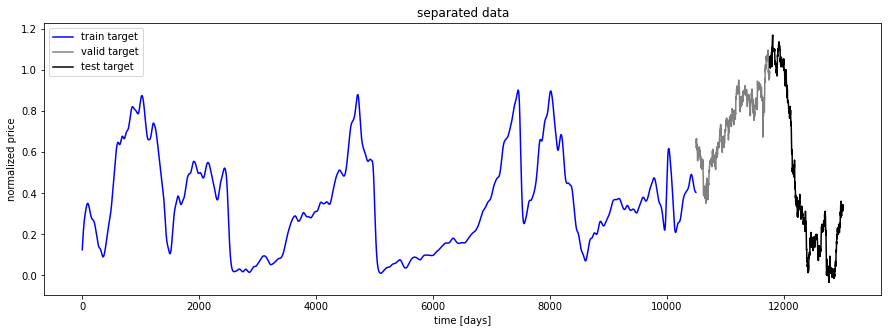

In [51]:
# looking at preprocessed data

plt.figure(figsize = (15, 5))
plt.plot(np.arange(y_train_2.shape[0]), y_train_2, color = 'blue', label = 'train target')
plt.plot(np.arange(y_train_2.shape[0], y_train_2.shape[0]+y_valid.shape[0]), y_valid, color = 'gray', label = 'valid target')
plt.plot(np.arange(y_train_2.shape[0]+y_valid.shape[0], y_train_2.shape[0]+ y_valid.shape[0]+y_test.shape[0]), y_test, color = 'black', label = 'test target')

plt.title("separated data")
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc = 'best')


In [52]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [53]:
EPOCHS = 10
BATCH_SIZE = 1024
import time

NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

'60-SEQ-1-PRED-1620262531'